In [1]:
import numpy as np
import keras
import keras.backend as k
from keras.models import Sequential, Model
from keras.layers import Activation
from keras.layers.core import Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from keras.callbacks import ModelCheckpoint
from keras.applications import mobilenet
from keras.models import load_model
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix
%matplotlib inline

Using TensorFlow backend.


In [2]:
#Set Random Seeds to Constant For Sake of Reproducibility 
import numpy as np
import tensorflow as tf
import random as rn
import os

os.environ['PYTHONHASHSEED']= '0'
np.random.seed(0)
rn.seed(0)
tf.set_random_seed(0)

In [3]:
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [4]:
train_path = r'E:\SkinCancerDetection\Train'
valid_path = r'E:\SkinCancerDetection\Valid'
test_path = r'E:\SkinCancerDetection\Test'
model_path = r'E:\SkinCancerDetection\ModelData'

In [5]:
train_dataGen = ImageDataGenerator(rotation_range=90,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     shear_range=0.15,
                     zoom_range=0.1,
                     horizontal_flip=True,
                     vertical_flip=True,
                     preprocessing_function=mobilenet.preprocess_input
                )
valid_dataGen = ImageDataGenerator(preprocessing_function=mobilenet.preprocess_input)
test_dataGen = ImageDataGenerator(preprocessing_function=mobilenet.preprocess_input)

In [6]:
train_batches = train_dataGen.flow_from_directory(directory=train_path, target_size=(224, 224), classes=['Benign', 'Malignant'], class_mode='binary', batch_size=91)
valid_batches = valid_dataGen.flow_from_directory(directory=valid_path, target_size=(224, 224), classes=['Benign', 'Malignant'], class_mode='binary', batch_size=10)
test_batches = test_dataGen.flow_from_directory(directory=test_path, target_size=(224, 224), classes=['Benign', 'Malignant'], class_mode='binary', batch_size=460, shuffle=False)

Found 3640 images belonging to 2 classes.
Found 460 images belonging to 2 classes.
Found 460 images belonging to 2 classes.


In [7]:
mobilenet_model = mobilenet.MobileNet(input_shape=(224, 224, 3))

In [8]:
mobilenet_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (Activation)      (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (Activation)  (None, 112, 112, 32)      0         
__________

In [9]:
x = mobilenet_model.layers[-4].output
x = Flatten()(x)
prediction = Dense(1, activation='sigmoid')(x)
model = Model(input = mobilenet_model.input, output=prediction)

C:\Users\BHARATHAN\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  after removing the cwd from sys.path.


In [10]:
for layer in model.layers[:-23]:
    layer.trainable = False
print(model.layers[-14])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (Activation)      (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (Activation)  (None, 112, 112, 32)      0         
__________

In [11]:
model.load_weights(r'E:\SkinCancerDetection\ModelData\MobileNet_weights.hdf5')
checkpoint=ModelCheckpoint(filepath=r'E:\SkinCancerDetection\ModelData\MobileNet_weights.hdf5', monitor='val_acc', verbose=0,
                 save_best_only=True, save_weights_only=False,
                 mode='max', period=1)
callbacks_list = [checkpoint]

In [ ]:
model.compile(optimizer=Adam(lr=0.0000001), loss='binary_crossentropy', metrics=['accuracy'])
model.fit_generator(generator=train_batches, steps_per_epoch=40, epochs=5, callbacks=callbacks_list, validation_data=valid_batches, validation_steps=46)

In [ ]:
model.save(r'E:\SkinCancerDetection\ModelData\skinCancerMobileNet_model_1.hdf5')
model.save_weights(r'E:\SkinCancerDetection\ModelData\MobileNet_weights_end.hdf5')

In [ ]:
from tensorflow.python.keras._impl.keras.utils.generic_utils import CustomObjectScope
from tensorflow.python.keras._impl.keras.applications import mobilenet
with CustomObjectScope({'relu6': mobilenet.relu6,'DepthwiseConv2D': mobilenet.DepthwiseConv2D}):
    m = load_model(r'E:\SkinCancerDetection\ModelData\skinCancerMobileNet_model_1.h5')

In [12]:
train_data = ImageDataGenerator(preprocessing_function=mobilenet.preprocess_input).flow_from_directory(directory=train_path, target_size=(224, 224), classes=['Benign', 'Malignant'], class_mode='binary', batch_size=3640, shuffle = False)
imgs, labels = next(train_data)

Found 3640 images belonging to 2 classes.


In [13]:
test_imgs, test_labels = next(test_batches)

In [14]:
predictions = model.predict(imgs, verbose = 1)
#for i in predictions:
#    print(i)

3640/3640 [==============================] - 1082s  


In [15]:
test_predictions = model.predict(test_imgs, verbose = 1)

460/460 [==============================] - 150s   


In [16]:
cm = confusion_matrix(labels, (predictions>0.5))

Confusion matrix, without normalization
[[1785   35]
 [  42 1778]]


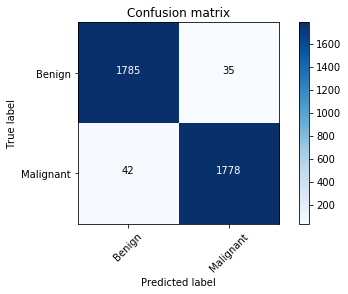

In [17]:
plot_confusion_matrix(cm, classes=['Benign', 'Malignant'])

In [18]:
cm_test = confusion_matrix(test_labels, (test_predictions>0.5))

Confusion matrix, without normalization
[[230   0]
 [ 18 212]]


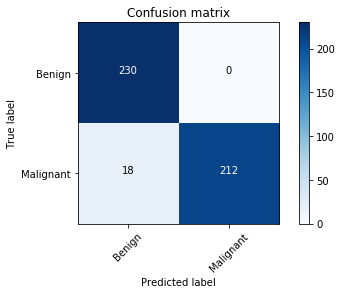

In [19]:
plot_confusion_matrix(cm_test, classes=['Benign', 'Malignant'])